In [ ]:
!nvidia-smi

Sat Nov 21 09:20:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!unzip '/content/drive/My Drive/train_400X400.zip' 
!unzip '/content/drive/MyDrive/Aerial_Image_Mismatch/train_building.zip'
#!unzip '/content/drive/MyDrive/Aerial_Image_Mismatch/224X224X3_1600_Black/train.zip'

Archive:  /content/drive/MyDrive/Aerial_Image_Mismatch/train_building.zip
  inflating: trainX.hkl              
  inflating: trainY.hkl              


In [5]:
!pip install hickle
import hickle as hkl 
trainX = hkl.load('/content/trainX.hkl')
trainY = hkl.load('/content/trainY.hkl')

     |████████████████████████████████| 51kB 5.5MB/s 


In [6]:
import numpy as np
X = []
Y = []
for i, img in enumerate(trainY):
  r,c,v = img.shape
  if (r == 224) and (c==224) and (255 in img):
    X.append(trainX[i]/np.max(trainX[i]))
    Y.append(img/255)

In [7]:
np.array(X).shape

(1553, 224, 224, 3)

(224, 224, 3)


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fa43f66b0b8>)

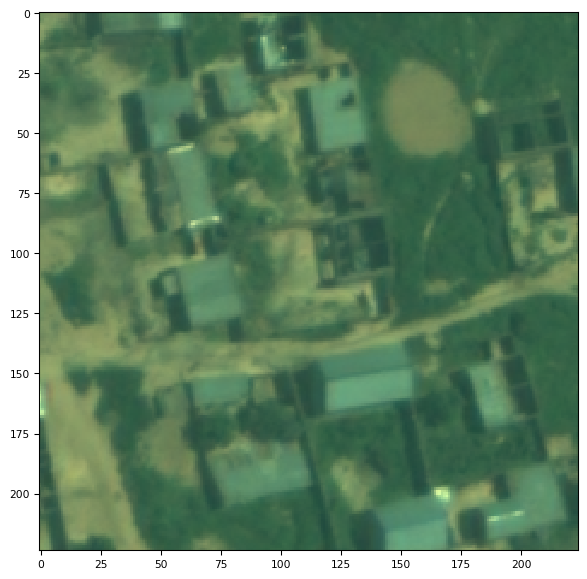

In [ ]:
import tifffile as tiff
print(X[400].shape)
tiff.imshow(X[400])

(224, 224, 3)
[0. 1.]


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2008016cf8>)

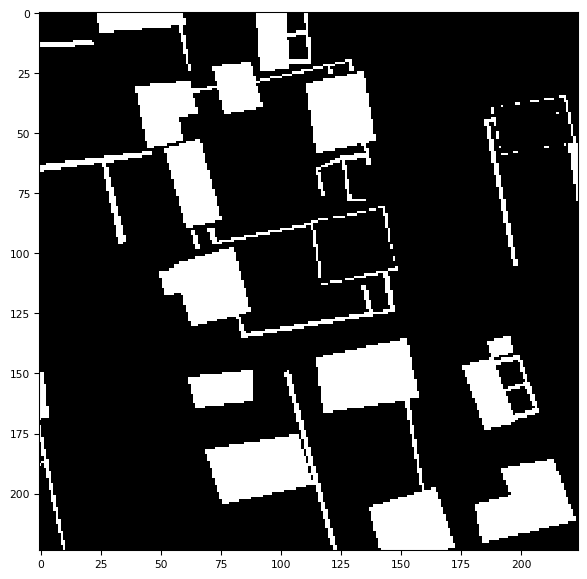

In [ ]:
print(Y[400].shape)
print(np.unique(Y[400]))
tiff.imshow(Y[400])

In [8]:
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
import cv2
import tifffile as tiff
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow import keras
import os
from keras import backend as K

In [9]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    smooth=1e-6
    intersection = K.sum(K.abs(y_true * y_pred), axis=[0, -1, -2])
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)



In [11]:

def get_inception(inp, filt):
    
    #1X1 conv
    conv1 = Conv2D(filters = filt/4,kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv1 = Activation('relu')(conv1)
    conv1 = BatchNormalization()(conv1)

    #1X1_3X3 conv
    conv2 = Conv2D(filters = filt/4,kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(filters = filt/4,kernel_size = (3,3), padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = BatchNormalization()(conv2)

    #1X1_5X5 conv
    conv3 = Conv2D(filters = filt/4,kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(inp)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(filters = filt/4,kernel_size = (5,5), padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = BatchNormalization()(conv3)

    #3X3 maxpool 1X1 conv
    pool4 = tf.nn.max_pool2d(inp, ksize = (3,3), strides=1, padding='SAME')
    conv4 = Conv2D(filters = filt/4,kernel_size = (1,1), padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv4 = Activation('relu')(conv4)
    conv4 = BatchNormalization()(conv4)

    concat = concatenate([conv1, conv2, conv3, conv4])
    #concat = BatchNormalization()(concat)
    return(concat)

In [12]:
def get_Model():
    inpt = Input((224,224,3))
    print(inpt.shape)
    conv1 = get_inception(inpt, 64)
    conv1 = get_inception(conv1, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv1)
    
    conv2 = get_inception(pool1, 128)
    conv2 = get_inception(conv2, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv2)
    
    conv3 = get_inception(pool2, 256)
    conv3 = get_inception(conv3, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv3)
    
    conv4 = get_inception(pool3, 512)
    conv4 = get_inception(conv4, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2), strides = 2)(conv4)

    conv5 = get_inception(pool4, 1024)
    conv5 = get_inception(conv5, 1024)
    
    up1 = Conv2DTranspose(512, (2, 2), strides=2, padding='same')(conv5)
    up1 = concatenate([up1,conv4])
    conv6 = get_inception(up1, 512)
    conv6 = get_inception(conv6, 512)
    
    up2 = Conv2DTranspose(256, (2, 2), strides=2, padding='same')(conv6)
    up2 = concatenate([up2,conv3])
    conv7 = get_inception(up2, 256)
    conv7 = get_inception(conv7, 256)
    
    up3 = Conv2DTranspose(128, (2, 2), strides=2, padding='same')(conv7)
    up3 = concatenate([up3,conv2])
    conv8 = get_inception(up3, 128)
    conv8 = get_inception(conv8, 128)

    up4 = Conv2DTranspose(64, (2, 2), strides=2, padding='same')(conv8)
    up4 = concatenate([up4,conv1])
    conv9 = get_inception(up4, 64)
    conv9 = get_inception(conv9, 64)

    
    conv = Conv2D(3, (1,1), activation='sigmoid', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    print(conv.shape)


    model = Model(inpt, conv)
    model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = [jaccard_coef, 'accuracy'])
    return model

In [13]:
model = get_Model()

(None, 224, 224, 3)
(None, 224, 224, 3)


In [ ]:
model.summary()

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = [ModelCheckpoint(filepath='/content/checks',
                            save_weights_only=False,
                            monitor='val_accuracy',
                            mode='max',
                            save_best_only=True),
              EarlyStopping(monitor='val_loss',
                            patience=10,
                            mode='auto',
                            min_delta=0.001,
                            verbose = 1)]
            
valX = X[1400:]
valY = Y[1400:]
val_data=(np.array(valX), np.array(valY))
results = model.fit(np.array(X[:1400]), np.array(Y[:1400]), validation_data= val_data, batch_size=8, epochs=500, callbacks= checkpoint)

Epoch 1/500
175/175 [==============================] - ETA: 0s - loss: 0.4803 - jaccard_coef: 0.2070 - accuracy: 0.5861WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/checks/assets
175/175 [==============================] - 68s 389ms/step - loss: 0.4803 - jaccard_coef: 0.2070 - accuracy: 0.5861 - val_loss: 0.5042 - val_jaccard_coef: 0.0076 - val_accuracy: 0.6043
Epoch 2/500
175/175 [==============================] - 31s 177ms/step - loss: 0.2810 - jaccard_coef: 0.3121 - accuracy: 0.6365 - val_loss: 0.3551 - val_jaccard_coef: 0

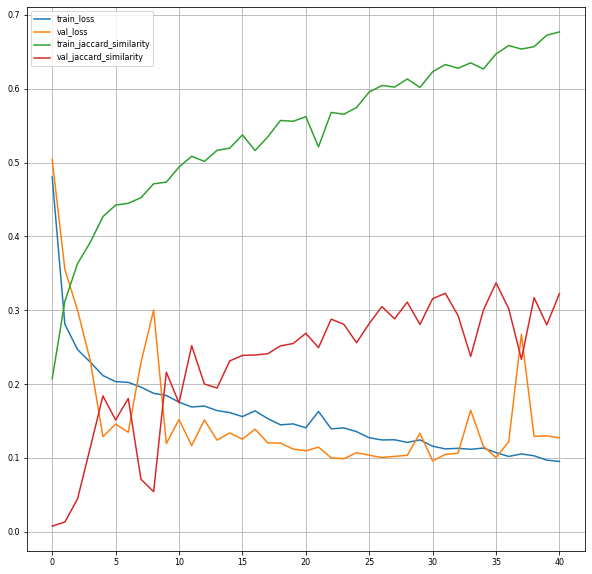

In [38]:
model.save('/content/model_building.h5')
plt.figure(figsize=(10,10))
plt.plot(results.history['loss'], label = 'train_loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.plot(results.history['jaccard_coef'], label = 'train_jaccard_similarity')
plt.plot(results.history['val_jaccard_coef'], label = 'val_jaccard_similarity')
plt.legend()
plt.grid()
plt.show()

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2d8609f160>)

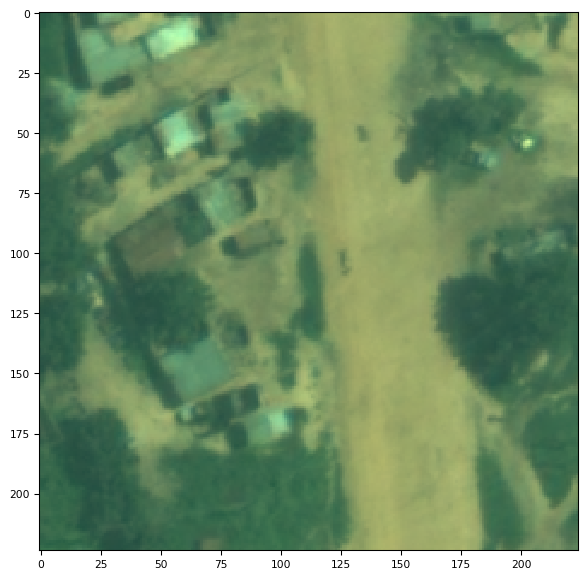

In [19]:
tiff.imshow(X[561])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2ba694a6a0>)

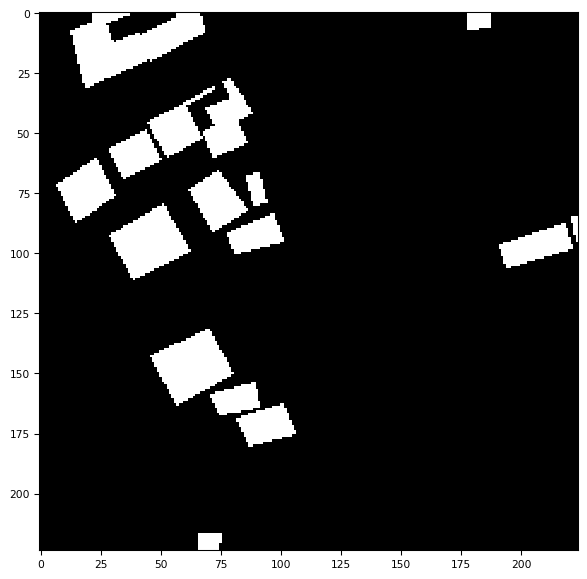

In [18]:
tiff.imshow(Y[561])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2ba5dd8438>)

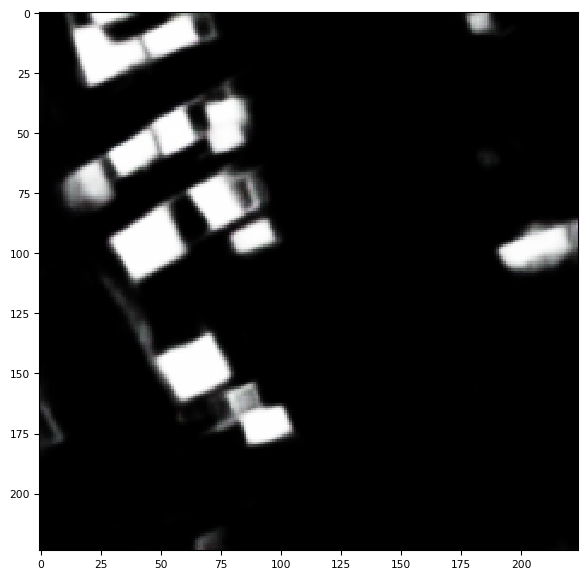

In [20]:
pred = model.predict(np.reshape(X[561], (-1,224,224,3)))
#pred = pred * 255
tiff.imshow(pred)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2b8d8d88d0>)

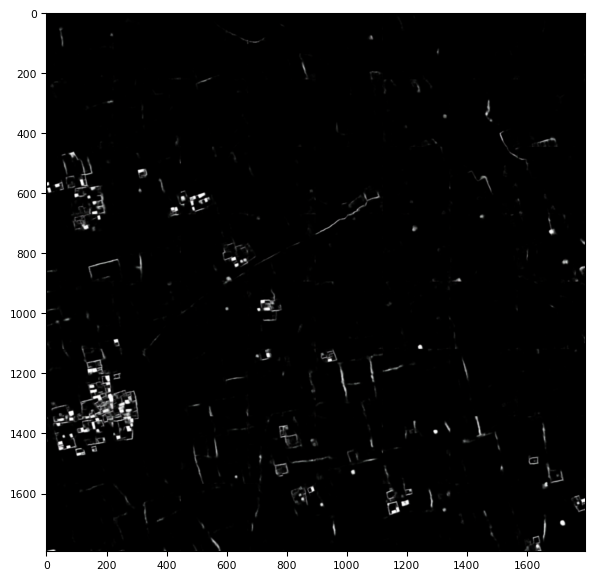

In [30]:
data = tiff.imread('/content/drive/MyDrive/Aerial_Image_Mismatch/6030_0_0.tif').transpose([1, 2, 0])
w,h = data.shape[:2]
split = []
hstart = 0
for i in range(1,9):
    hend = (h/8)*i
    wstart=0 
    
    temp = []
    for j in range(1,9):
        wend = (w/8)*j
        test= data[int(hstart):int(hend), int(wstart):int(wend)]
        img = cv2.resize(test,(224,224), cv2.INTER_AREA)
        img = img/np.max(img)
        pred = model.predict(np.reshape(img, (-1,224,224,3)))
        pred = pred[0,:,:,:3]
        #pred = pred * 255
        temp.append(pred)
        wstart = wend
    split.append(np.concatenate([temp[0],temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[7]], axis=1))
    hstart = hend
pred = np.concatenate([split[0],split[1],split[2],split[3],split[4],split[5],split[6],split[7]], axis=0)
tiff.imshow(pred)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f2b9f60aa90>)

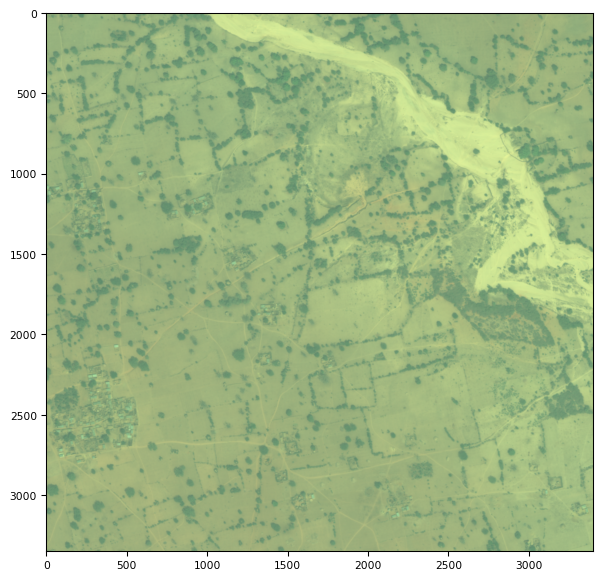

In [31]:
tiff.imshow(data)